# Image Classification Using CNN

### Importing Required Libraries

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

import cv2
import os
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.15.0


### Loading the data set

In [4]:
import os
os.chdir("/content/drive/MyDrive/Deep Learning Exam")

In [5]:
!dir

dataset  test_examples	Untitled0.ipynb


### CNN Model Architecture

In [20]:
# create CNN model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):

        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, channel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5,5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5,5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(100, (5,5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [21]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar: # devdattasupnekar.ds@gmail.com

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Boots":
            label = 0
        elif label == "Sandals":
            label = 1
        elif label == "Slippers":
            label = 2

        labels.append(label)

        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/787 [00:00<?, ?it/s]

In [22]:
data[0].shape

(28, 28, 3)

In [23]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [24]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [25]:
trainX.shape

(590, 28, 28, 3)

In [26]:
trainY.shape

(590,)

In [27]:
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [28]:
trainY[0]

array([0., 0., 1.], dtype=float32)

In [29]:
# Data Preprocessing (Augumentation)

In [30]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [31]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [32]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 20)        1520      
                                                                 
 activation_5 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_6 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 50)          0         
 g2D)                                                 

In [33]:
# train the network

EPOCH  = 150
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCH,
              verbose=1)


# save the model and label binarizer to disk
print("[INFO] serializing network ...")
model.save("cnn_model_{}.h5".format(EPOCH))

[INFO] training network...
Epoch 1/150
18/18 [==============================] - 7s 53ms/step - loss: 1.0514 - accuracy: 0.4194 - val_loss: 0.9031 - val_accuracy: 0.5431
Epoch 2/150
18/18 [==============================] - 0s 20ms/step - loss: 0.8397 - accuracy: 0.6057 - val_loss: 0.8102 - val_accuracy: 0.5787
Epoch 3/150
18/18 [==============================] - 0s 20ms/step - loss: 0.7588 - accuracy: 0.6183 - val_loss: 0.5304 - val_accuracy: 0.7817
Epoch 4/150
18/18 [==============================] - 0s 22ms/step - loss: 0.6281 - accuracy: 0.7025 - val_loss: 0.4888 - val_accuracy: 0.7766
Epoch 5/150
18/18 [==============================] - 0s 21ms/step - loss: 0.6286 - accuracy: 0.6953 - val_loss: 0.5802 - val_accuracy: 0.7259
Epoch 6/150
18/18 [==============================] - 0s 20ms/step - loss: 0.5685 - accuracy: 0.7384 - val_loss: 0.4467 - val_accuracy: 0.7716
Epoch 7/150
18/18 [==============================] - 0s 20ms/step - loss: 0.5618 - accuracy: 0.7312 - val_loss: 0.4971 - 

### Model Evaluation

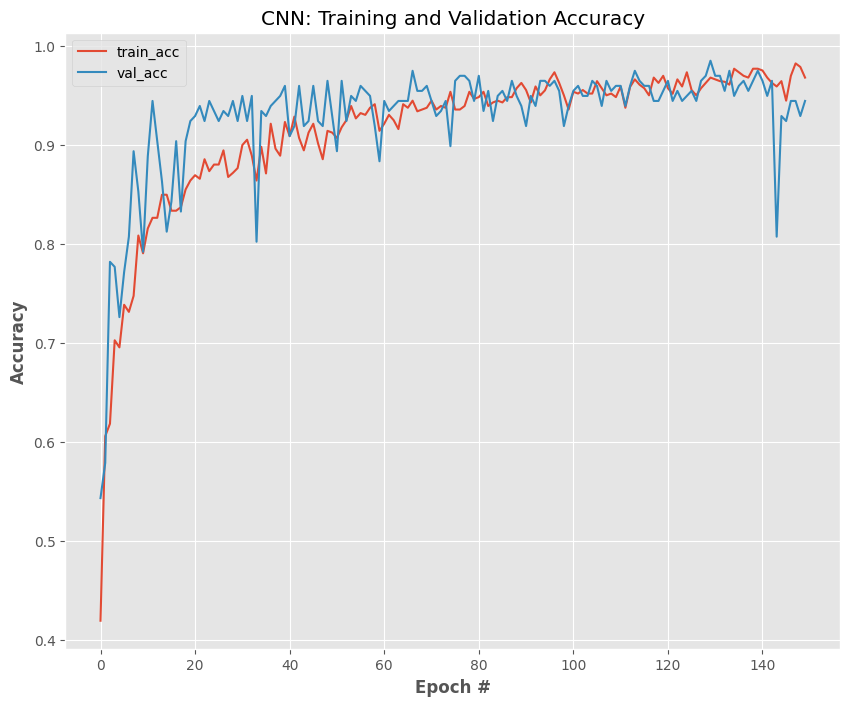

In [34]:
_# plot the training and validation accuracy
N = np.arange(0, 150)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

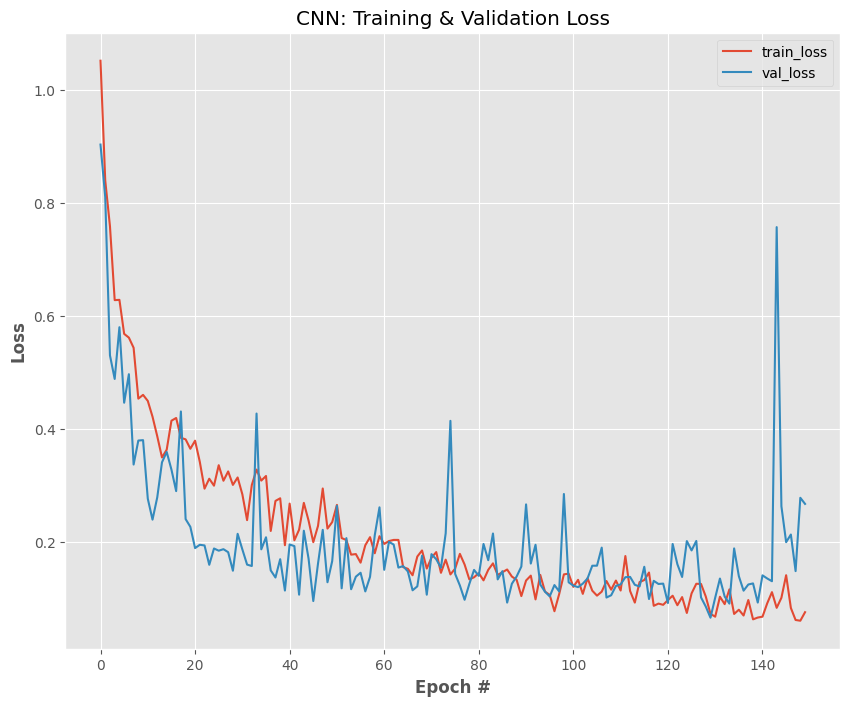

In [35]:
# plot the training and validation loss
N = np.arange(0, 150)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

### **Classification Report**

In [43]:
# Classification Report for the model on the training data
predictions = model.predict(testX, batch_size=BS)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(testY.argmax(axis=1), predicted_labels))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        84
           1       0.93      0.94      0.93        81
           2       0.86      0.97      0.91        32

    accuracy                           0.94       197
   macro avg       0.93      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



In [36]:
!dir

cnn_model_150.h5  dataset  test_examples  Untitled0.ipynb


In [38]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    # plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [39]:
# load the model
print("[INFO] loading network and...")
model = load_model("cnn_model_150.h5")

[INFO] loading network and...


In [ ]:
# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Boots", "Sandals", "Slippers"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)